In [11]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

In [12]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
import numpy as np

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[0] == '1' else [0, 1])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences

train_targets_src, train_data_src = read_data('../data/datasets/restaurant_v3_test.txt')

In [14]:
# Helper function for converting to bigraph

from discopy.rigid import Id as RigidId

def checkTrailingCups(diagram):
    scanWords = True
    
    for box in diagram.boxes:
        if not box.dom and not scanWords:
            return False
        else:
            scanWords = scanWords and not box.dom
    
    return True

def convertToTrailingCups(diagram):
    if (checkTrailingCups(diagram)):
        return diagram

    words = []
    cups = []
    
    for box in diagram.boxes:
        if not box.dom:
            words = words + [box]
        else:
            cups = [box] + cups
    
    new_diag = words[0]
    
    for i, word in enumerate(words):
        if i != 0:
            new_diag = new_diag >> RigidId(new_diag.cod) @ word
    
    for i, cup in enumerate(cups):
        if i != len(cups)-1:
            new_diag = new_diag >> RigidId(new_diag.cod[:-2]) @ cup
        else:
            new_diag = new_diag >> cup @ RigidId(new_diag.cod[2:])
    
    return new_diag

In [15]:
# Fucntion for stemming and lemmatization of tokens

def to_word_tokens(data):
    return [word_tokenize(record) for record in data]

def build_stem_dictionary(data):
    port = PorterStemmer()
    wnet = WordNetLemmatizer()
    
    mapping = {}
    
    data_as_tokens = to_word_tokens(data)
    
    for words in data_as_tokens:
        for word in words:
            if word not in mapping:
                stemmed_word = port.stem(word)
                lemmatized_word = wnet.lemmatize(stemmed_word)
                
                mapping[word] = lemmatized_word
    
    return mapping

In [16]:
# Function for stemming and lemmatization of diagram boxes

from lambeq.rewrite import RewriteRule

class StemRewriteRule(RewriteRule):
    def __init__(self, data):
        self.mapping = build_stem_dictionary(data)
    
    def matches(self, box):
        return box.name in self.mapping

    def rewrite(self, box):
        new_name = self.mapping[box.name]
        return type(box)(name=new_name, dom=box.dom, cod=box.cod)

In [17]:
from lambeq.ansatz import CircuitAnsatz
from abc import abstractmethod
# from collections.abc import Mapping
from itertools import cycle
from typing import Callable, Optional, Tuple, Mapping
from discopy.quantum.circuit import (Circuit, Functor, Id, qubit)
from discopy.quantum.gates import Bra, Ket, Controlled, Rotation
from discopy.quantum.gates import H, X, Y, Z, Rx, Ry, Rz
from discopy.rigid import Box, Diagram, Ty
from discopy.tensor import Dim, Tensor
import numpy as np
from sympy import Symbol, symbols

class GeneralQCLayer(Circuit):
    
    def __init__(self, n_qubits, params):
        from discopy.quantum.gates import Rx, Rz

        if len(self.gate_layers) != 2:
            raise ValueError("Expected gate_layers as tuple of strings")
        
        g1, g2 = self.gate_layers

        if (g1 == None) or (g2 == None):
            raise ValueError("gate_layers must be in discopy.quantum.gates")
        # if not (abs(self.r1) == 1 and abs(self.r2) == 1) and ((abs(self.r1) == 1 or abs(self.r2) == 1) and (self.r2 % self.r1 == 0 or self.r1 % self.r2 == 0)) or (n_qubits % self.r1 == 0 and self.r1 != 1) or (n_qubits % self.r2 == 0 and self.r2 != 1):
        #     raise ValueError("n_qubits, r1, and r2 must be co-prime")

        params_shape = np.shape(params)

        if n_qubits == 1:
            if len(params) == 0:
                circuit = Id(1)
            else:
                circuit = Rx(params[0]) >> Rz(params[1]) >> Rx(params[2])
        elif (len(params_shape) != 2):
            raise ValueError(
                "Expected params of shape (depth, {})".format(n_qubits))
        else:
            g1_thetas = 0
            g2_thetas = 0

            if g1.free_symbols != {}:
                # g1 is fixed
                g1_thetas = n_qubits
            if g2.free_symbols != {}:
                g2_thetas = n_qubits

            if self.reuse_params:
                self.k = 1
            else:
                self.k = 2
            
            n_thetas = self.k*(g1_thetas + g2_thetas)

            if (params_shape[1] != n_thetas):
                raise ValueError(
                    "Expected component params with length {}".format(n_thetas))

            # ANSATZ ALGORITHM
            circuit = Id(n_qubits)
            
            # for {theta} in labelled params
            for thetas in params:
                
                # sublayer 1 non-entangling block
                if g1_thetas == 0:
                    # if g1 is fixed
                    sublayer1 = Id().tensor(*([g1 for _ in range(n_qubits)]))
                else:
                    # if g1 is trainable
                    sublayer1 = Id().tensor(*([g1(theta) for theta in thetas[:g1_thetas]]))
                
                # sublayer 1 entangled block
                ctrl = 0

                for i in range(n_qubits):
                    # shift target := control - r1
                    tgt = (ctrl - self.r1) % n_qubits
                    
                    if g2_thetas == 0:
                        sublayer1 = sublayer1._apply_controlled(g2, ctrl, tgt)
                        # sublayer1 = sublayer1.CX(ctrl, tgt)
                    else:
                        sublayer1 = sublayer1._apply_controlled(g2(thetas[g1_thetas + i]), ctrl, tgt)
                        # sublayer1 = sublayer1.CRx(thetas[g1_thetas + i], ctrl, tgt)
                    
                    ctrl = tgt
                
                # sublayer 2 non-entangling block
                if g1_thetas == 0:
                    sublayer2 = Id().tensor(*([g1 for _ in range(n_qubits)]))
                else:
                    if self.reuse_params:
                        sublayer2 = Id().tensor(*([g1(theta) for theta in thetas[:g1_thetas]]))
                    else:
                        sublayer2 = Id().tensor(*([g1(theta) for theta in thetas[g1_thetas+g2_thetas:2*g1_thetas+g2_thetas]]))
                
                # sublayer 2 entangled block
                ctrl = 0

                for i in range(n_qubits):
                    # shift target := control - r2
                    tgt = (ctrl - self.r2) % n_qubits

                    if g2_thetas == 0:
                        sublayer2 = sublayer2._apply_controlled(g2, ctrl, tgt)
                        # sublayer2 = sublayer2.CX(ctrl, tgt)
                    else:
                        if self.reuse_params:
                            sublayer2 = sublayer2._apply_controlled(g2(thetas[g1_thetas + i]), ctrl, tgt)
                        else:
                            sublayer2 = sublayer2._apply_controlled(g2(thetas[2*g1_thetas+g2_thetas+i]), ctrl, tgt)
                            # sublayer2 = sublayer2.CRx(thetas[2*g1_thetas+g2_thetas+i], ctrl, tgt)
                    
                    ctrl = tgt
            
                # compose circuit
                circuit >>= sublayer1 >> sublayer2
            
        super().__init__(
            circuit.dom, circuit.cod, circuit.boxes, circuit.offsets)

class GeneralQCAnsatz(CircuitAnsatz):
    def __init__(self, ob_map: Mapping[Ty, int], n_layers: int, n_single_qubit_params: int = 0, gate_config = {"gate_layers": [H, Rx], "var_layers": 1}, r = (1, 3), reuse_params=True, discard: bool = False) -> None:
        self.gate_config = gate_config
        self.reuse_params = reuse_params
        self.r = r
        
        class GeneralQCInterface(GeneralQCLayer):
            """ Interface for GeneralQCLayer """

            def strToGate(gateStr):
                if gateStr == "H":
                    return H
                if gateStr == "X":
                    return X
                if gateStr == "Y":
                    return Y
                if gateStr == "Z":
                    return Z
                if gateStr == "Rx":
                    return Rx
                if gateStr == "Ry":
                    return Ry
                if gateStr == "Rz":
                    return Rz
                
                return Id(1)
            
            assert(len(self.gate_config["gate_layers"]) == 2)

            g1, g2 = self.gate_config["gate_layers"]

            if isinstance(g1, str):
                g1 = strToGate(g1)
            if isinstance(g2, str):
                g2 = strToGate(g2)

            gate_layers = [g1, g2]
            r1, r2 = self.r
            reuse_params = self.reuse_params

        super().__init__(ob_map, n_layers, n_single_qubit_params, GeneralQCInterface, discard, [Rx, Rz])

    def params_shape(self, n_qubits: int) -> Tuple[int, ...]:
        if self.reuse_params:
            k = 1
        else:
            k = 2
        
        return (self.n_layers, k*self.gate_config["var_layers"]*n_qubits)

In [18]:
from lambeq import BobcatParser, Rewriter, remove_cups
from discopy import grammar
from discopy.quantum.gates import X, Z
from discopy import rigid

def sentences_to_circuits(sentences, ansatz, convert_bigraph=True, not_representation="X", all_sentences=None, return_valids_mask=True):
    ### SENTENCES TO DIAGRAMS ###

    if all_sentences is None:
        all_sentences = sentences
    
    # syntax tree parsing
    parser = BobcatParser()
    raw_diagrams = parser.sentences2diagrams([text.replace(" not ", " ") for text in sentences])

    # filter valid diagrams type S
    n_sent = len(sentences)

    valids_mask = np.array([d.cod.name == Ty('s').name for d in raw_diagrams])
    data = [sentences[i] for i in range(n_sent) if valids_mask[i]]
    use_diagrams = [raw_diagrams[i] for i in range(n_sent) if valids_mask[i]]

    # grammatical rewrite rules
    rewriter = Rewriter()
    rewritten_diagrams = [rewriter(diagram) for diagram in use_diagrams]

    # bigraph method
    normalised_diagrams = [convertToTrailingCups(diagram.normal_form()) for diagram in rewritten_diagrams]

    removed_diagrams = [remove_cups(diagram) for diagram in normalised_diagrams]

    # stemming and lemmatization
    stemmed_diagrams = [Rewriter([StemRewriteRule(all_sentences)])(diagram) for diagram in removed_diagrams]

    # final diagrams
    diagrams = [diagram for diagram in stemmed_diagrams]

    ### DIAGRAMS to CIRCUITS ###

    # string diagrams to raw quantum circuits
    circuits = [ansatz(diagram) for diagram in diagrams]

    # apply NOT box to circuits
    for i, circuit in enumerate(circuits):
        if data[i].find(" not ") != -1:
            if (not_representation == "ZX"):
                circuits[i] = circuit >> Z >> X
            else:
                circuits[i] = circuit >> X
    
    if return_valids_mask:
        return data, diagrams, circuits, valids_mask
    else:
        return data, diagrams, circuits

In [19]:
from lambeq import AtomicType, IQPAnsatz
from discopy.quantum.gates import H, X, Y, Z, Rx, Ry, Rz

# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Convert string diagram to quantum circuit
iqp_ansatz = IQPAnsatz({N:1, S:1}, n_layers=1)
gqc_ansatz = GeneralQCAnsatz({N: 1, S: 1}, n_layers=1, n_single_qubit_params=0, gate_config={"gate_layers": ["Rx", "X"], "var_layers": 1}, r=(1, -1))

In [21]:
train_data, train_diagrams, gqc_circuits, train_valids_mask = sentences_to_circuits(train_data_src, gqc_ansatz)
train_targets = [train_targets_src[i] for i, mask in enumerate(train_valids_mask) if mask]

Tagging sentences:   0%|          | 0/15 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/60 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/60 [00:00<?, ?it/s]

In [22]:
train_data, train_diagrams, iqp_circuits, train_valids_mask = sentences_to_circuits(train_data_src, iqp_ansatz)
train_targets = [train_targets_src[i] for i, mask in enumerate(train_valids_mask) if mask]

Tagging sentences:   0%|          | 0/15 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/60 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/60 [00:00<?, ?it/s]

In [25]:
train_data[0]

'I hate the restaurant'

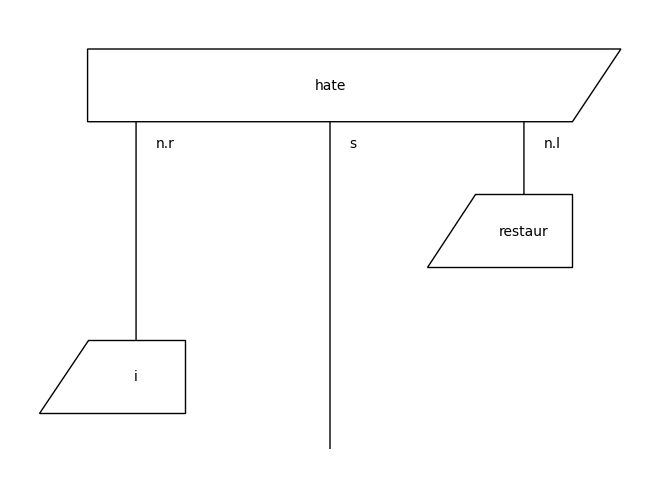

In [26]:
train_diagrams[0].draw()

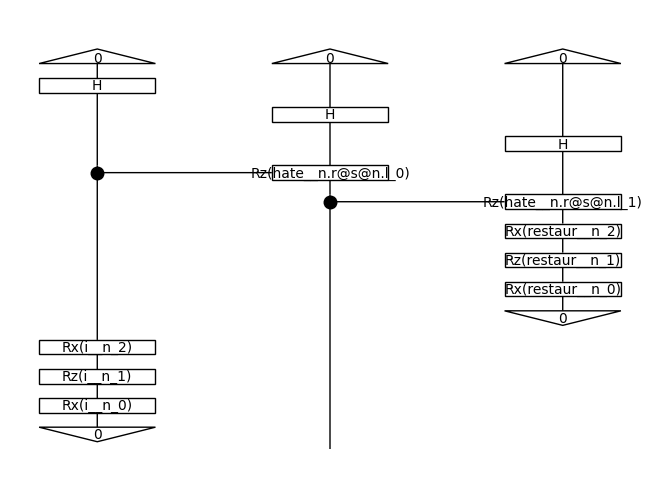

In [24]:
iqp_circuits[0].draw()

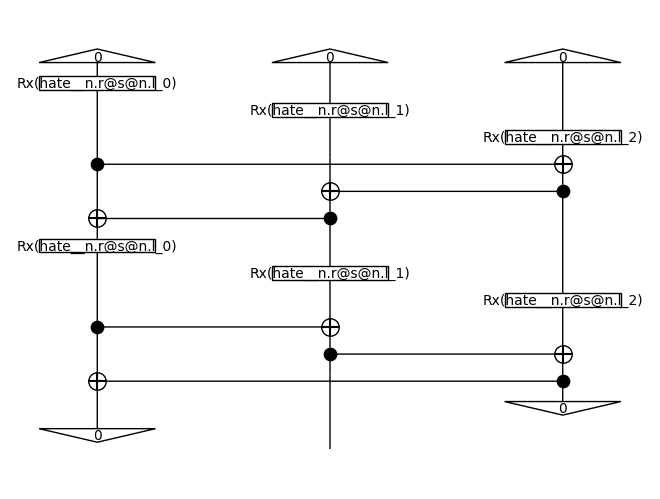

In [27]:
gqc_circuits[0].draw()

In [30]:
print(train_data[10])

The restaurant was bad


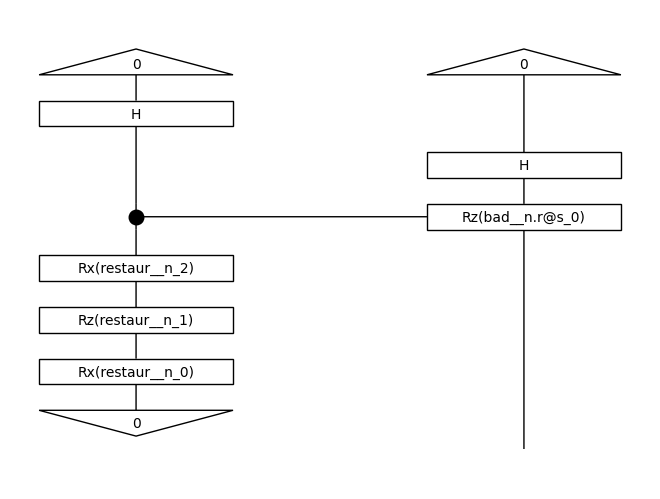

In [31]:
iqp_circuits[10].draw()